# Pygimli synthetic data study

## written by Anton Ziegon

<div class="alert alert-info">
<h4>Summary of this script</h4>

In this script the simplified geologic model (which was created in Gempy) is reproduced in pygimli. The Gempy model could not be used due to an error in the Gempy-to-pygimli-function (not yet fixed). Forward calculations of geophysical methods (ERT, TraveltimeTomography) are performed on the resulting Model/Mesh. The resulting synthetic data will be inverted in the following Notebook.

In [43]:
# Importing pygimli
import  pygimli                 as     pg
import  pygimli.meshtools       as     mt
from    pygimli.physics         import ert
from    pygimli.physics         import TravelTimeManager

# Importing auxiliary libraries
import  numpy                   as     np
import  pandas                  as     pd
import  matplotlib.pyplot       as     plt
from    matplotlib.patches      import PathPatch 
import  os

%matplotlib inline

# Setting options
seed_val = 420
np.random.seed(seed_val)
pd.set_option('precision', 2)

## Parameter settings

In [44]:
# Material properties
class Soil:
    rho = 100       # electrical resistivity in Ohmm
    v   = 650       # seismic velocity in m/s
    k   = 10**-10   # magnetic susceptibility
    
class SS:
    rho = 1200      # electrical resistivity in Ohmm
    v   = 3300      # seismic velocity in m/s (value related to sandstone with ~28% porosity)
    k   = 2*10**-4  # magnetic susceptibility
    
class CSS:
    rho = 3500      # electrical resistivity in Ohmm
    v   = 3800      # seismic velocity in m/s (value related to sandstone with ~20% porosity)
    k   = 4*10**-4  # magnetic susceptibility
    
class basement:
    rho = 10**8     # electrical resistivity in Ohmm
    v   = 4500      # seismic velocity in m/s (value related to sandstone with ~10% porosity)
    k   = 8*10**-4  # magnetic susceptibility
    
class Diatreme:
    rho = 10**5     # electrical resistivity in Ohmm
    v   = 2200      # seismic velocity in m/s
    k   = 0.12      # magnetic susceptibility
    
class ERT:
    e_start   = 5     # first electrode position
    e_end     = 125   # last electrode position
    n_elecs   = 121   # number of electrodes
    noiselev  = 1
    noiseabs  = 1e-6
    
class SRT:
    sensor_start = 1   # first geophone position
    sensor_end   = 141 # last geophone position
    n_sensors    = 36  # number of geophones
    noiselev     = 0.001
    noiseabs     = 0.001

## Creating Mesh with pygimli based on Gempy models 
(Loading model mesh did not work - error not fixed yet)

In [45]:
# Create layered subsurface
world = mt.createWorld([-20,-70], [150, 0], layers=[-10,-30,-60])

# Create surface points for Diatreme
pnts = [[20,-20], [30,-5], [50,-9], [70,-5], [80,-20]]
top = mt.createPolygon(pnts, addNodes=5, interpolate="spline")
left = mt.createLine([30,-70], pnts[0])
right = mt.createLine([70,-70], pnts[-1])

# Combine Diatreme and layered subsurface
geom = world + top + left + right

# Add RegionMarkers
for y in -9, -20, -50, -65:
    geom.addRegionMarker([50, y], 5)
for marker, y in enumerate([-20, -50, -65]):
    geom.addRegionMarker([100, y], marker + 2)

# Create mesh
geom_mesh = mt.createMesh(geom, area=10)
#mt.exportPLC(geom_mesh, 'mesh_combinedmodel.poly')

#Append a boundary region for forward calculations
#world_with_boundary = pg.meshtools.appendTriangleBoundary(world, marker=1, xbound=10, ybound=10)

Text(0.5, 1.0, 'Resulting Mesh')

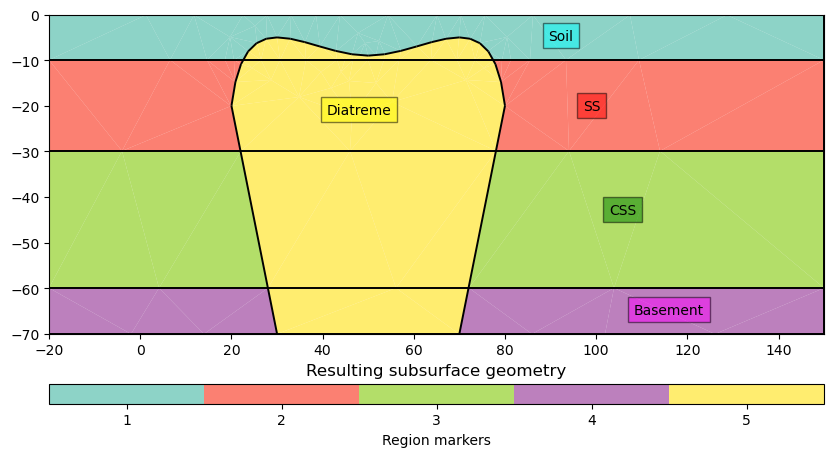

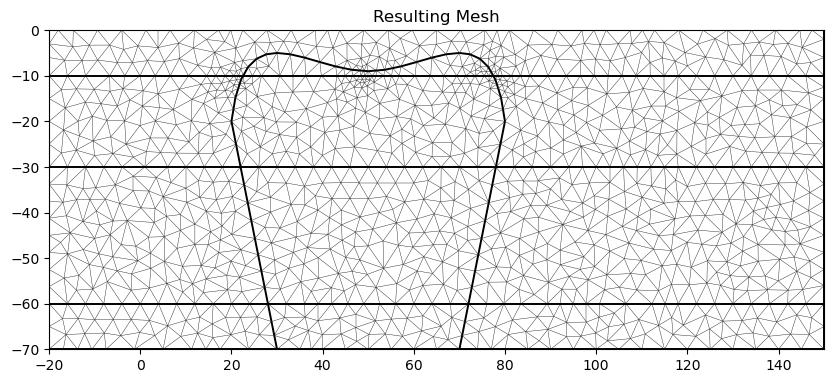

In [46]:
# Visualization of geometry
pg.show(geom)
plt.title('Resulting subsurface geometry')
# Notes
plt.text(2.8, 18.2, 'Soil', horizontalalignment='center', bbox=dict(facecolor='cyan', alpha=0.5))
plt.text(3, 14.7, 'SS', horizontalalignment='center', bbox=dict(facecolor='red', alpha=0.5))
plt.text(3.2, 9.5, 'CSS', horizontalalignment='center', bbox=dict(facecolor='green', alpha=0.5))
plt.text(3.5, 4.5, 'Basement', horizontalalignment='center', bbox=dict(facecolor='magenta', alpha=0.5))
plt.text(1.5, 14.5, 'Diatreme', horizontalalignment='center', bbox=dict(facecolor='yellow', alpha=0.5))
plt.savefig('combined_mesh.pdf')

# Visualization of mesh
pg.show(geom_mesh)
plt.title('Resulting Mesh')

### Mapping resistivity values to formations

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x1da8721fd60>)

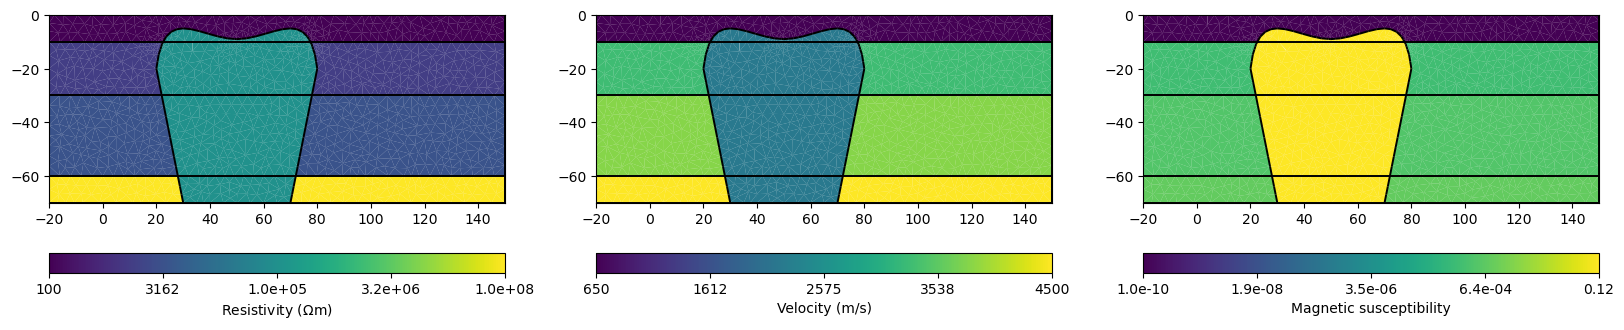

In [47]:
#Mapping typical matrial properties to units
rhomap = [[1,Soil.rho], [2,SS.rho], [3,CSS.rho], [4,basement.rho], [5,Diatreme.rho]]
vmap = [[1,Soil.v],[2,SS.v],[3,CSS.v],[4,basement.v], [5,Diatreme.v]]
kmap = [[1,Soil.k],[2,SS.k], [3,CSS.k], [4,basement.k], [5,Diatreme.k]]

#mesh = mt.createMesh(world)
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 20))   
pg.show(geom_mesh, ax=ax1, data = rhomap, label = pg.unit('res'), colorBar =True, logScale=True)
pg.show(geom_mesh, ax=ax2, data = vmap, label = pg.unit('vel'), colorBar =True, logScale=False)
pg.show(geom_mesh, ax=ax3, data = kmap, label = 'Magnetic susceptibility', colorBar =True, logScale=True)

### ERT forward calculation

In [48]:
# Defining ERT measurement schemes
ERT_scheme_dd = ert.createData(elecs=np.linspace(start=ERT.e_start, stop=ERT.e_end, num=ERT.n_elecs),
                           schemeName='dd')

ERT_scheme_slm = ert.createData(elecs=np.linspace(start=ERT.e_start, stop=ERT.e_end, num=ERT.n_elecs),
                           schemeName='slm')

ERT_scheme_wa = ert.createData(elecs=np.linspace(start=ERT.e_start, stop=ERT.e_end, num=ERT.n_elecs),
                           schemeName='wa')

(<AxesSubplot:>, None)

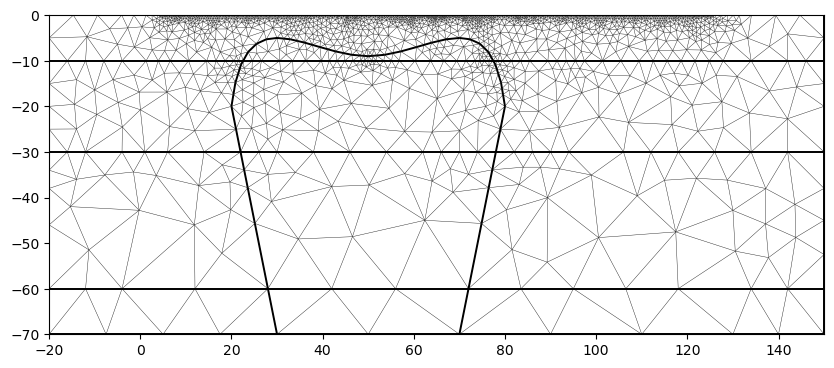

In [49]:
# Create Nodes at electrode positions for improving numerical accuracy
for s in ERT_scheme_dd.sensors():
    geom.createNode(s + [0.0, -0.2])
ert_mesh = mt.createMesh(geom, quality=33)
pg.show(ert_mesh)

12/12/22 - 21:12:19 - pyGIMLi - INFO - Calculate geometric factors.
12/12/22 - 21:12:20 - pyGIMLi - INFO - Calculate geometric factors.


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.010000176680440098 : 0.018941973991497513
relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.01000005962315603 : 0.01001803537279321


12/12/22 - 21:12:22 - pyGIMLi - INFO - Calculate geometric factors.


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.01000005962315603 : 0.010000508176457543


Text(0.5, 1.0, 'Wenner')

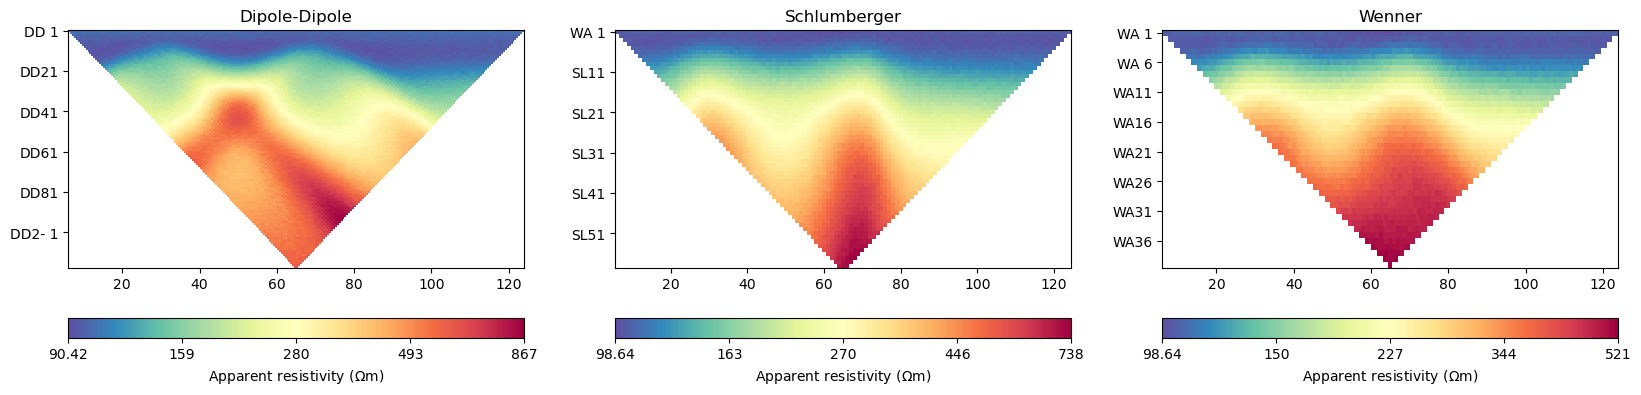

In [50]:
# Simulating data
ert_data_dd = ert.simulate(ert_mesh, res=rhomap, scheme=ERT_scheme_dd, verbose=True,
                           noiseLevel=ERT.noiselev,noiseAbs=ERT.noiseabs, seed=seed_val)
ert_data_slm = ert.simulate(ert_mesh, res=rhomap, scheme=ERT_scheme_slm, verbose=True,
                           noiseLevel=ERT.noiselev,noiseAbs=ERT.noiseabs, seed=seed_val)
ert_data_wa = ert.simulate(ert_mesh, res=rhomap, scheme=ERT_scheme_wa, verbose=True,
                           noiseLevel=ERT.noiselev,noiseAbs=ERT.noiseabs, seed=seed_val)

# Inspecting data
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 4)) 
ert.show(ert_data_dd, ax=ax1)
ert.show(ert_data_slm, ax=ax2)
ert.show(ert_data_wa, ax=ax3)
ax1.set_title('Dipole-Dipole')
ax2.set_title('Schlumberger') 
ax3.set_title('Wenner') 

### Seismic refraction tomography

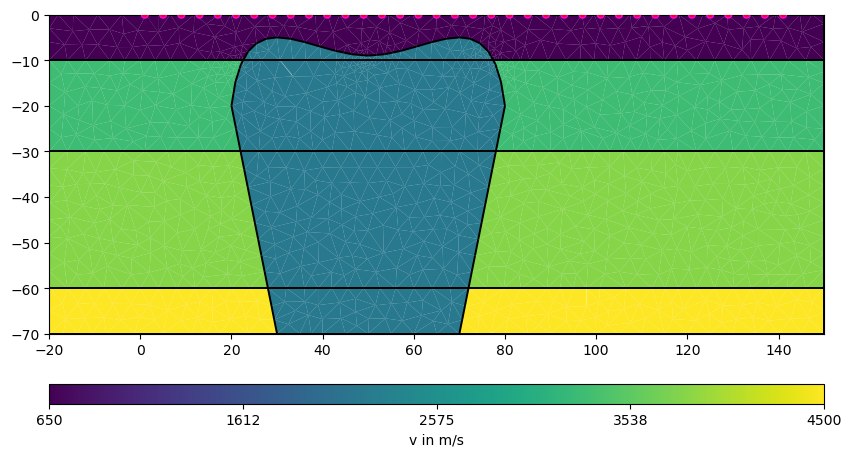

In [51]:
# Defining SRT measurement schemes
SRT_scheme = pg.physics.traveltime.createRAData(np.linspace(SRT.sensor_start, SRT.sensor_end, SRT.n_sensors))

# Visual Inspection
ax, _ = pg.show(geom_mesh, vmap, colorBar=True, logScale=False, label='v in m/s')
pg.viewer.mpl.drawSensors(ax, SRT_scheme.sensors(), diam=1.5, facecolor='red', edgecolor='magenta')

# Assign velocity to nodes
vp = np.array(geom_mesh.cellMarkers())
vp[vp == vmap[0][0]] = vmap[0][1]
vp[vp == vmap[1][0]] = vmap[1][1]
vp[vp == vmap[2][0]] = vmap[2][1]
vp[vp == vmap[3][0]] = vmap[3][1]
vp[vp == vmap[4][0]] = vmap[4][1]

12/12/22 - 21:12:26 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.


((<matplotlib.image.AxesImage at 0x1da89138e50>,
  <matplotlib.colorbar.Colorbar at 0x1da897ad7f0>),
 None)

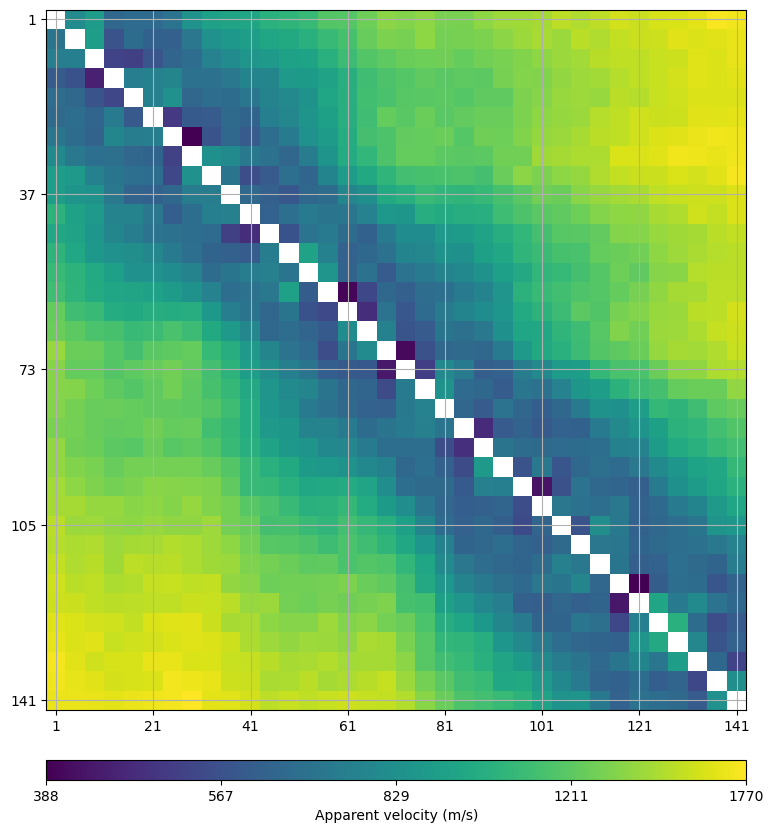

In [52]:
# Simulating data
mgr = TravelTimeManager()
data = mgr.simulate(slowness=1.0 / vp, scheme=SRT_scheme, mesh=geom_mesh,
                    noiseLevel=SRT.noiselev, noiseAbs=SRT.noiseabs, seed=seed_val,
                    verbose=True)
# Insecting data
mgr.showData(data)